# Preparação do ambiente

## Bibliotecas

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd
import re
import unidecode

from datetime import datetime
from joblib import dump

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from string import punctuation

In [2]:
import warnings
warnings.filterwarnings("ignore") 
if os.name=='posix':
    os.environ['PYTHONWARNINGS']='ignore'

## Constantes e funções auxiliares

In [3]:
FILE_MARKETPLACES = '../datasets/experimento_gs/marketplaces.parquet'
FILE_SUPERVISAO_MERCADO = '../datasets/experimento_gs/supervisao_mercado.xlsx'
FILE_HYPER_PARAMETERS = '../datasets/experimento_gs/gs_hyper_paramenters_classifiers.json'

N_JOBS = os.cpu_count()//2

In [4]:
def load_file_mercado(file_mercado=FILE_SUPERVISAO_MERCADO):
    dict_df_mercado = pd.read_excel(
    file_mercado,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'titulo', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

    df_list = []
    for key in dict_df_mercado.keys():
        df = dict_df_mercado[key]
        df['marketplace'] = key
        df_list.append(df)
        
    df_mercado = pd.concat(df_list)
    df_mercado = df_mercado.dropna()
    df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)
    
    map_marketplaces = {
        'Amazon': 'Amazon', 
        'Americanas': 'Lojas Americanas',
        'CasasBahia': 'Casas Bahia',
        'Magalu': 'Magazine Luiza', 
        'MercadoLivre': 'Mercado Livre'
    }
    
    df_mercado['marketplace'] = df_mercado['marketplace'].map(map_marketplaces)

    return df_mercado

In [5]:
def save_best_params():
    
    _best_params = {
        'name': gs.best_estimator_['clf'].__class__.__name__,
        'best_params': json.dumps(gs.best_params_),
        'mean_fit_time': gs.cv_results_['mean_fit_time'].mean(),
        'timestamp': datetime.now().timestamp(),
        'train_auc': gs.best_score_,
        'train_accuracy': gs.score(X_test,y_test),
    }

    # test accuracy and roc_auc_score
    test_accuracy = gs.best_estimator_.score(X_test,y_test)
    valid_accuracy = gs.best_estimator_.score(X_valid,y_valid)
    
    if hasattr(gs.best_estimator_['clf'],'predict_proba'):
        y_test_score = gs.best_estimator_.predict_proba(X_test)[:,1]
        y_valid_score = gs.best_estimator_.predict_proba(X_valid)[:,1]
    else:
        y_test_score = gs.best_estimator_.decision_function(X_test)
        y_valid_score = gs.best_estimator_.decision_function(X_valid)
        
    test_auc = roc_auc_score(y_test,y_test_score)
    valid_auc = roc_auc_score(y_valid,y_valid_score)

    _best_params['test_auc'] = test_auc
    _best_params['test_accuracy'] = test_accuracy

    _best_params['valid_auc'] = valid_auc
    _best_params['valid_accuracy'] = valid_accuracy

    # confusion matrix
    y_pred = gs.predict(X_valid)
    cm = confusion_matrix(y_valid,y_pred)
    tn = int(cm[0][0])
    fn = int(cm[1][0])
    tp = int(cm[1][1])
    fp = int(cm[0][1])
    
    confusion = {
        'tn': tn, 
        'fn': fn, 
        'tp': tp, 
        'fp': fp
    }

    _best_params['confusion'] = json.dumps(confusion)
    
    if osp.exists(FILE_HYPER_PARAMETERS):
        with open(FILE_HYPER_PARAMETERS, 'r') as f:
            clf_best_params = json.load(f) 
    else:
        clf_best_params = []
    
    clf_best_params.append(_best_params)
    
    df = pd.DataFrame(clf_best_params)
    df = df.sort_values(by=['test_auc','test_accuracy', 'timestamp'], ascending=False).reset_index(drop=True)
    df = df.drop_duplicates(subset='name',keep='first')

    # save best params
    clf_best_params = df.to_dict('records')
    with open(FILE_HYPER_PARAMETERS, 'w+') as f:
        json.dump(clf_best_params,f,indent=2)

    # save model
    pipe = gs.best_estimator_
    clf_name = pipe['clf'].__class__.__name__
    clf_joblib_file = f'../datasets/experimento_gs/models/{clf_name}.joblib'
    with open(clf_joblib_file,'wb') as f:
        dump(pipe, f)
    
    return df

In [6]:
def load_best_params():

    with open(FILE_HYPER_PARAMETERS) as f:
        clf_best_params = json.load(f)
        
    return pd.DataFrame(clf_best_params)

# Carga e prepação dos dados

In [7]:
df_marketplaces = pd.read_parquet(FILE_MARKETPLACES)
df_mercado = load_file_mercado()

# reduzir a base de dados para construir o notebook
# df_marketplaces = df_marketplaces.sample(10)

# conjunto de dados
docs_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo'].values
targets_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao'].values

# Split data to keep experiment results comparable
X_train, X_test, y_train, y_test = train_test_split(
    docs_marketplaces, targets_marketplaces,
    test_size=0.25, 
    random_state=724
)

X_valid, y_valid = df_mercado['titulo'].values, df_mercado['passivel_homologacao'].values

# Análise


https://levity.ai/blog/text-classifiers-in-machine-learning-a-practical-guide

## Ajustando hiperparâmetros dos algoritmos

In [8]:
start_time = datetime.now()

### DummyClassifier

In [9]:
%%time
clf = DummyClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__strategy": ('most_frequent', 'prior', 'stratified', 'uniform', 'constant'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 1.43 s, sys: 263 ms, total: 1.69 s
Wall time: 4.32 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.369813,1.727724e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""cholesky""}",4.930805,1.727124e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.316040,1.727724e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
7,MultinomialNB,"{""clf__alpha"": 1.0}",0.284796,1.727724e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
8,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.271521,1.727724e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
9,BernoulliNB,"{""clf__alpha"": 1.0}",0.340190,1.727724e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


### NaiveBayes

#### BernoulliNB

In [10]:
%%time
clf = BernoulliNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)

save_best_params()

CPU times: user 1.43 s, sys: 71.6 ms, total: 1.5 s
Wall time: 3.58 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.369813,1.727724e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""cholesky""}",4.930805,1.727124e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.316040,1.727724e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
7,MultinomialNB,"{""clf__alpha"": 1.0}",0.284796,1.727724e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
8,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.271521,1.727724e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
9,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


#### ComplementNB

In [11]:
%%time
clf = ComplementNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 1.75 s, sys: 67.2 ms, total: 1.82 s
Wall time: 3.82 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.369813,1.727724e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""cholesky""}",4.930805,1.727124e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
8,MultinomialNB,"{""clf__alpha"": 1.0}",0.284796,1.727724e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
9,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.271521,1.727724e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


#### MultinomialNB

In [12]:
%%time
clf = MultinomialNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe, parameter_grid, scoring=scoring, refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 1.9 s, sys: 117 ms, total: 2.02 s
Wall time: 4.24 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.369813,1.727724e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""cholesky""}",4.930805,1.727124e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
7,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
9,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.271521,1.727724e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


### KNeighborsClassifier

In [13]:
%%time
clf = KNeighborsClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_neighbors": (3, 5, 10),
    "clf__p": (1, 2)
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 7.32 s, sys: 2.08 s, total: 9.41 s
Wall time: 15.1 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.369813,1.727724e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""cholesky""}",4.930805,1.727124e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
7,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
8,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


### Linear models

#### SGDClassifier

In [14]:
%%time
clf = SGDClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
    "clf__loss": ('hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'),
    "clf__penalty": ('l1', 'l2', 'elasticnet'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 11.1 s, sys: 857 ms, total: 11.9 s
Wall time: 43.3 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.369813,1.727724e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
5,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
6,RidgeClassifier,"{""clf__solver"": ""cholesky""}",4.930805,1.727124e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
7,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
8,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
9,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


#### LogisticRegression

In [15]:
%%time
clf = LogisticRegression(solver='liblinear')

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__C": np.logspace(-5, 5, 11),
    "clf__penalty": ('l1', 'l2'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 3.93 s, sys: 253 ms, total: 4.18 s
Wall time: 5.94 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
5,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
6,RidgeClassifier,"{""clf__solver"": ""cholesky""}",4.930805,1.727124e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
7,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
8,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
9,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


#### RidgeClassifier

In [16]:
%%time
clf = RidgeClassifier(fit_intercept=False)

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__solver": ('cholesky', 'sparse_cg', 'sag', 'saga'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 2.28 s, sys: 112 ms, total: 2.39 s
Wall time: 18.3 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""sparse_cg""}",4.685139,1.727725e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
7,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
8,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
9,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


### SVM

#### LinearSVC

In [17]:
%%time
clf = LinearSVC()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__loss": ('hinge', 'squared_hinge'),
    "clf__C": np.logspace(-5,0,6),
    "clf__tol": np.logspace(-5,0,6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 4.38 s, sys: 345 ms, total: 4.72 s
Wall time: 16.4 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",11.354448,1.727125e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
6,RidgeClassifier,"{""clf__solver"": ""sparse_cg""}",4.685139,1.727725e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
7,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
8,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
9,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


#### NuSVC

In [18]:
%%time
clf = NuSVC()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__nu": (0.1, 0.25, 0.5, 0.75, 1),
    "clf__kernel": ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),
    "clf__tol": np.logspace(-5,0,6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 1min 1s, sys: 2.51 s, total: 1min 3s
Wall time: 15min 17s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",16.598989,1.727726e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
2,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
3,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
4,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
5,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
6,RidgeClassifier,"{""clf__solver"": ""sparse_cg""}",4.685139,1.727725e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
7,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
8,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
9,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


### Tree

#### DecisionTreeClassifier

In [19]:
%%time
clf = DecisionTreeClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__splitter": ('best', 'random'),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 1.34 s, sys: 91.3 ms, total: 1.43 s
Wall time: 3.2 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",16.598989,1.727726e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""sparse_cg""}",4.685139,1.727725e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
7,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
8,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
9,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


#### Extremely randomized tree 

In [20]:
%%time
clf = ExtraTreeClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__splitter": ('best', 'random'),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 1.66 s, sys: 57.1 ms, total: 1.72 s
Wall time: 3.76 s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",16.598989,1.727726e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""sparse_cg""}",4.685139,1.727725e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
7,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
8,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
9,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


### Ensemble

#### RandomForestClassifier

In [21]:
%%time
clf = RandomForestClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_estimators": (10, 100, 500),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 1min 17s, sys: 768 ms, total: 1min 17s
Wall time: 3min 39s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",16.598989,1.727726e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
3,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
4,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
5,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
6,RidgeClassifier,"{""clf__solver"": ""sparse_cg""}",4.685139,1.727725e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
7,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
8,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
9,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
10,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


#### AdaBoostClassifier

In [22]:
%%time
clf = AdaBoostClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_estimators": (50, 100, 500),
    "clf__learning_rate": np.logspace(-5, 0, 6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: user 42.4 s, sys: 561 ms, total: 43 s
Wall time: 1min 50s


,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",16.598989,1.727726e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""sparse_cg""}",4.685139,1.727725e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
7,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
8,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
9,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


## Consolidar e exibir resultados

### Tempo de treinamento

In [23]:
elapsed_time = datetime.now() - start_time
print('Total trainning time: {} seconds'.format(int(elapsed_time.total_seconds())))
print('Total trainning time: {} minutes'.format(int(elapsed_time.total_seconds()//60)))

Total trainning time: 1369 seconds
Total trainning time: 22 minutes


### Scores

In [24]:
df = load_best_params()
df

,name,best_params,mean_fit_time,timestamp,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,confusion
0,NuSVC,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__...",16.598989,1.727726e+09,0.969549,0.971635,0.971635,0.927799,0.957585,0.907801,"{""tn"": 103, ""fn"": 18, ""tp"": 665, ""fp"": 60}"
1,RandomForestClassifier,"{""clf__criterion"": ""log_loss"", ""clf__max_featu...",57.431853,1.727127e+09,0.969653,0.971072,0.971072,0.915153,0.964888,0.888889,"{""tn"": 82, ""fn"": 13, ""tp"": 670, ""fp"": 81}"
2,SGDClassifier,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.395110,1.727724e+09,0.967485,0.969976,0.969976,0.917452,0.953911,0.886525,"{""tn"": 86, ""fn"": 19, ""tp"": 664, ""fp"": 77}"
3,LogisticRegression,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.549632,1.727725e+09,0.967770,0.969649,0.969649,0.916762,0.955196,0.891253,"{""tn"": 92, ""fn"": 21, ""tp"": 662, ""fp"": 71}"
4,LinearSVC,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.277607,1.727724e+09,0.966858,0.968364,0.968364,0.919522,0.951881,0.895981,"{""tn"": 96, ""fn"": 21, ""tp"": 662, ""fp"": 67}"
5,RidgeClassifier,"{""clf__solver"": ""sparse_cg""}",4.685139,1.727725e+09,0.966041,0.966690,0.966690,0.915153,0.947740,0.894799,"{""tn"": 98, ""fn"": 24, ""tp"": 659, ""fp"": 65}"
6,ComplementNB,"{""clf__alpha"": 1.0}",0.415025,1.727725e+09,0.958971,0.957040,0.957040,0.902046,0.954657,0.880615,"{""tn"": 72, ""fn"": 10, ""tp"": 673, ""fp"": 91}"
7,MultinomialNB,"{""clf__alpha"": 1.0}",0.492348,1.727725e+09,0.958971,0.957040,0.957040,0.894229,0.954657,0.875887,"{""tn"": 62, ""fn"": 4, ""tp"": 679, ""fp"": 101}"
8,KNeighborsClassifier,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.431874,1.727725e+09,0.953880,0.956598,0.956598,0.906875,0.897444,0.877069,"{""tn"": 80, ""fn"": 21, ""tp"": 662, ""fp"": 83}"
9,BernoulliNB,"{""clf__alpha"": 1.0}",0.448694,1.727725e+09,0.956049,0.953859,0.953859,0.895838,0.949052,0.879433,"{""tn"": 69, ""fn"": 8, ""tp"": 675, ""fp"": 94}"


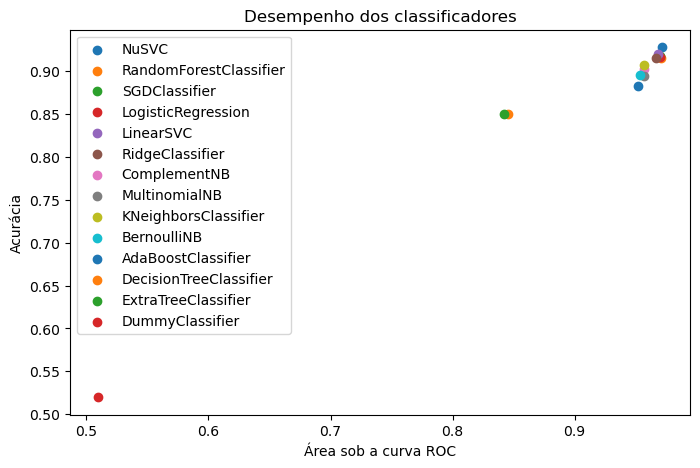

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

for record in df.to_dict('records'):
    label = record['name']
    x = record['test_auc']
    y = record['test_accuracy']
    _=ax.scatter(x,y, label=label)

ax.set_xlabel('Área sob a curva ROC')
ax.set_ylabel('Acurácia')
ax.set_title('Desempenho dos classificadores')
ax.legend()
plt.show()

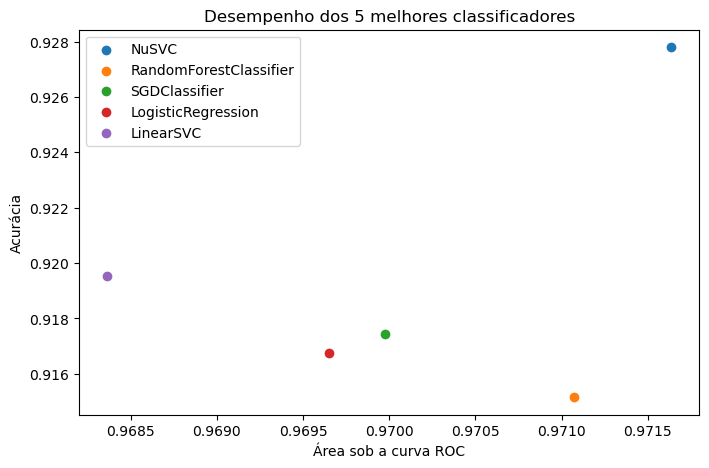

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

for record in df.head(5).to_dict('records'):
    label = record['name']
    x = record['test_auc']
    y = record['test_accuracy']
    _=ax.scatter(x,y, label=label)

ax.set_xlabel('Área sob a curva ROC')
ax.set_ylabel('Acurácia')
ax.set_title('Desempenho dos 5 melhores classificadores')
ax.legend()
plt.show()